<a href="https://colab.research.google.com/github/rho-selynn/592-HW3/blob/Roselynn/592_HW3_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Mar 29 13:30:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

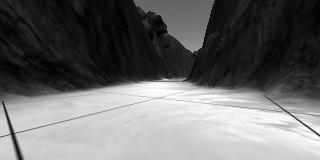

(1000, 160, 320)


In [ ]:
from torch import int64
import cv2 
import os 
import glob 
from google.colab.patches import cv2_imshow
import numpy as np
import torch
img_dir = "Images"
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
Images = [] 
for f1 in files: 
    img = cv2.imread(f1, 0) 
    Images.append(img)
Images = np.array(Images)
cv2_imshow(Images[0])
print(np.shape(Images))
Images = (np.divide(Images, 255))
Images = Images.astype(float)

In [ ]:
controlData = np.loadtxt('Robot Log/robot_log.csv', delimiter = ';', skiprows = 1, usecols = (1,2,3), dtype = float)
controlData  /= 15
print(np.amax(controlData))
print(controlData)

1.0
[[0.         0.         0.06666667]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In [ ]:
from torch.utils.data import TensorDataset
ImagesTrain = torch.tensor(Images[0:800])
steerDataTrain = torch.tensor(controlData[0:800, 0])
trainSteerDataset = TensorDataset(ImagesTrain, steerDataTrain)
ImagesTest = torch.tensor(Images[801:999])
steerDataTest = torch.tensor(controlData[801:999, 0])
testSteerDataset = TensorDataset(ImagesTest, steerDataTest)
throttleDataTrain = torch.tensor(controlData[0:800, 1])
trainThrottleDataset = TensorDataset(ImagesTrain, throttleDataTrain)
throttleDataTest = torch.tensor(controlData[801:999, 1])
testThrottleDataset = TensorDataset(ImagesTest, throttleDataTest)

In [ ]:
steerTrainDataLoader = torch.utils.data.DataLoader(trainSteerDataset, batch_size=64, shuffle=True)
steerTestDataLoader = torch.utils.data.DataLoader(testSteerDataset, batch_size=64, shuffle=False)
throttleTrainDataLoader = torch.utils.data.DataLoader(trainThrottleDataset, batch_size=64, shuffle=True)
throttleTestDataLoader = torch.utils.data.DataLoader(testThrottleDataset, batch_size=64, shuffle=False)

In [ ]:
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear1 = torch.nn.Linear(160*320, 128) # W:784x128 , b:128x1 , parameters = [W,b]
        self.linear2 = torch.nn.Linear(128, 10)
        self.linear3 = torch.nn.Linear(10, 1)
    
    def forward(self, x):
        x = x.view(-1,160*320)
        transformed_x1 = self.linear1(x)
        transformed_x2 = self.linear2(transformed_x1)
        transformed_x3 = self.linear3(transformed_x2)
        return transformed_x3
Steernet = LR()
Steeroptimizer = torch.optim.Adam(Steernet.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
Thrustnet = LR()
Thrustoptimizer = torch.optim.Adam(Thrustnet.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [ ]:

train_loss_history = []
test_loss_history = []
for epoch in range(20):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(steerTrainDataLoader):
        images, labels = data
        images = images.to(torch.float32)
        labels = labels.to(torch.float32)
        Steeroptimizer.zero_grad()
        predicted_output = Steernet(images.float())
        predicted_output = predicted_output.to(torch.float32)
        loss = criterion(predicted_output, labels)
        loss.backward()
        Steeroptimizer.step()
        train_loss += loss.item()
    for i, data in enumerate(steerTestDataLoader):
        with torch.no_grad():
            images, labels = data
            predicted_output = Steernet(images.float())
            loss = criterion(predicted_output, labels.long())
            test_loss += loss.item()
    train_loss = train_loss/len(steerTrainDataLoader)
    test_loss = test_loss/len(steerTestDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print('Epoch %s finished with train loss %s and test loss %s'%(epoch, train_loss, test_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Epoch 0 finished with train loss 123047.26793257777 and test loss 29621.2353515625
Epoch 1 finished with train loss 12573.86684681819 and test loss 2220.3916625976562
Epoch 2 finished with train loss 2421.189896620237 and test loss 853.228271484375
Epoch 3 finished with train loss 702.871447123014 and test loss 58.321556091308594
Epoch 4 finished with train loss 163.42301471416766 and test loss 11.61970591545105
Epoch 5 finished with train loss 31.42687078622671 and test loss 18.643069744110107
Epoch 6 finished with train loss 9.47873434653649 and test loss 10.814413070678711
Epoch 7 finished with train loss 6.204978521053608 and test loss 4.955151677131653
Epoch 8 finished with train loss 4.001361736884484 and test loss 3.3262534737586975
Epoch 9 finished with train loss 3.048059005003709 and test loss 2.533676028251648
Epoch 10 finished with train loss 2.5793551481687107 and test loss 2.0956283807754517
Epoch 11 finished with train loss 2.1168256447865414 and test loss 1.727718740701

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
predicted_output = Steernet(images.float())
loss = criterion(predicted_output, labels)
print(predicted_output)
print(labels)
print('loss:' + str(loss))

tensor([[0.4093],
        [0.4251],
        [0.4544],
        [0.3692],
        [0.4341],
        [0.4237],
        [0.3474],
        [0.4074],
        [0.4786],
        [0.4102],
        [0.4201],
        [0.3999],
        [0.4369],
        [0.4320],
        [0.4207],
        [0.4623],
        [0.4061],
        [0.4347],
        [0.4133],
        [0.4135],
        [0.4457],
        [0.4183],
        [0.3504],
        [0.4499],
        [0.4296],
        [0.3940],
        [0.4135],
        [0.4294],
        [0.3941],
        [0.3515],
        [0.4287],
        [0.4534],
        [0.4564],
        [0.3315],
        [0.4135],
        [0.3973],
        [0.4135],
        [0.3241],
        [0.3775],
        [0.4429],
        [0.4259],
        [0.4277],
        [0.4327],
        [0.4488],
        [0.4843],
        [0.3521],
        [0.4127],
        [0.4168],
        [0.3894],
        [0.4095],
        [0.4189],
        [0.4581],
        [0.4129],
        [0.4553],
        [0.4135],
        [0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
train_loss_history = []
test_loss_history = []
for epoch in range(20):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(throttleTrainDataLoader):
        images, labels = data
        images = images.to(torch.float32)
        labels = labels.to(torch.float32)
        Thrustoptimizer.zero_grad()
        predicted_output = Thrustnet(images.float())
        predicted_output = predicted_output.to(torch.float32)
        loss = criterion(predicted_output, labels)
        loss.backward()
        Thrustoptimizer.step()
        train_loss += loss.item()
    for i, data in enumerate(throttleTestDataLoader):
        with torch.no_grad():
            images, labels = data
            predicted_output = Thrustnet(images.float())
            loss = criterion(predicted_output, labels.long())
            test_loss += loss.item()
    train_loss = train_loss/len(steerTrainDataLoader)
    test_loss = test_loss/len(steerTestDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print('Epoch %s finished with train loss %s and test loss %s'%(epoch, train_loss, test_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Epoch 0 finished with train loss 0.035119354008482054 and test loss 0.03895525215193629
Epoch 1 finished with train loss 0.032069939690140575 and test loss 0.03318167617544532
Epoch 2 finished with train loss 0.030259399459912226 and test loss 0.03215402411296964
Epoch 3 finished with train loss 0.02841646711413677 and test loss 0.029606620781123638
Epoch 4 finished with train loss 0.026580575710305802 and test loss 0.027498560957610607
Epoch 5 finished with train loss 0.02455295264147795 and test loss 0.028849771711975336
Epoch 6 finished with train loss 0.022707703738258436 and test loss 0.02543908776715398
Epoch 7 finished with train loss 0.021331677571512185 and test loss 0.02212241105735302
Epoch 8 finished with train loss 0.019603529945015907 and test loss 0.022273307433351874
Epoch 9 finished with train loss 0.0186730045825243 and test loss 0.020044469740241766
Epoch 10 finished with train loss 0.017218997988563318 and test loss 0.020244956947863102
Epoch 11 finished with train 